# Analysis, Val -> Test 
### Some analysis to better understand how Validation scores Correspond to Test (Competition Leader Board - LB) scores.

## Paths and Imports

In [68]:
import os
import sys
import lightgbm as lgb
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Setup paths
NOTEBOOK_DIR = os.getcwd()  # data_analysis
PROJ_DIR = os.path.dirname(NOTEBOOK_DIR)  # main project folder
MODEL_DIR = os.path.join(PROJ_DIR, "trained_models")
DATA_DIR = os.path.join(PROJ_DIR, "feature_enhanced_data/null_flags_and_forward_fill.parquet")

# Add training source to path for imports
sys.path.append(os.path.join(PROJ_DIR, "training"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src", "utils"))

# Import our utility functions
from src.data_loading import DataLoader
from src.utils.metrics import r2_score_weighted

## Some basic tree models, all trained for a standard number of branches but on different days

In [69]:
# Configuration
SEGMENT_LENGTH = 1  # Length of validation segments

# Define models and their training days
MODELS = [
    # Forward-trained models (starting from beginning)
    {"name": "first_250.txt", "train_start": 0, "train_end": 250},
    {"name": "first_500.txt", "train_start": 0, "train_end": 500},
    {"name": "first_750.txt", "train_start": 0, "train_end": 750},
    {"name": "first_1000.txt", "train_start": 0, "train_end": 1000},
    {"name": "first_1250.txt", "train_start": 0, "train_end": 1250},
    {"name": "first_1500.txt", "train_start": 0, "train_end": 1500},
    
    # Backward-trained models (ending at 1698)
    {"name": "last_250.txt", "train_start": 1448, "train_end": 1698},
    {"name": "last_500.txt", "train_start": 1198, "train_end": 1698},
    {"name": "last_750.txt", "train_start": 948, "train_end": 1698},
    {"name": "last_1000.txt", "train_start": 698, "train_end": 1698},
    {"name": "last_1250.txt", "train_start": 448, "train_end": 1698},
    {"name": "last_1500.txt", "train_start": 198, "train_end": 1698},
    
    # Middle-window models
    {"name": "500_to_1000.txt", "train_start": 500, "train_end": 1000},
    {"name": "800_to_1300.txt", "train_start": 800, "train_end": 1300},
    {"name": "900_to_1400.txt", "train_start": 900, "train_end": 1400},
    #{"name": "300_to_800.txt", "train_start": 300, "train_end": 800},
    {"name": "1000_to_1250.txt", "train_start": 1000, "train_end": 1250},
    {"name": "600_to_1100.txt", "train_start": 600, "train_end": 1100}, 
    {"name": "400_to_900.txt", "train_start": 400, "train_end": 900}, 
    {"name": "950_to_1300.txt", "train_start": 950, "train_end": 1300}, 
    {"name": "1000_to_1250.txt", "train_start": 1000, "train_end": 1250}, 
    {"name": "1100_to_1300.txt", "train_start": 1100, "train_end": 1300}
]

# Print training ranges for clarity
print("Training Ranges:")
print("-" * 50)
for model in MODELS:
    print(f"{model['name']:<15}: Days {model['train_start']:>4} to {model['train_end']:<4} "
          f"({model['train_end'] - model['train_start']} days)")

Training Ranges:
--------------------------------------------------
first_250.txt  : Days    0 to 250  (250 days)
first_500.txt  : Days    0 to 500  (500 days)
first_750.txt  : Days    0 to 750  (750 days)
first_1000.txt : Days    0 to 1000 (1000 days)
first_1250.txt : Days    0 to 1250 (1250 days)
first_1500.txt : Days    0 to 1500 (1500 days)
last_250.txt   : Days 1448 to 1698 (250 days)
last_500.txt   : Days 1198 to 1698 (500 days)
last_750.txt   : Days  948 to 1698 (750 days)
last_1000.txt  : Days  698 to 1698 (1000 days)
last_1250.txt  : Days  448 to 1698 (1250 days)
last_1500.txt  : Days  198 to 1698 (1500 days)
500_to_1000.txt: Days  500 to 1000 (500 days)
800_to_1300.txt: Days  800 to 1300 (500 days)
900_to_1400.txt: Days  900 to 1400 (500 days)
1000_to_1250.txt: Days 1000 to 1250 (250 days)
600_to_1100.txt: Days  600 to 1100 (500 days)
400_to_900.txt : Days  400 to 900  (500 days)
950_to_1300.txt: Days  950 to 1300 (350 days)
1000_to_1250.txt: Days 1000 to 1250 (250 days)
1100

In [70]:
def load_model(model_path: str) -> lgb.Booster:
    """Load the LightGBM model"""
    return lgb.Booster(model_file=model_path)

## See how they perorm on ANY day they weren't trained on

In [71]:
def create_validation_segments(df: pl.DataFrame, models: list, segment_length: int) -> dict:
    """Create list of validation segments for each model"""
    segments_by_model = {}
    
    for model in models:
        model_name = model['name']
        is_forward = model_name.startswith('first')
        is_backward = model_name.startswith('last')
        is_middle = not (is_forward or is_backward)
        
        if is_middle:
            # For middle models, evaluate both before and after training period
            before_days = (df.select('date_id')
                          .unique()
                          .filter(pl.col('date_id') < model['train_start'])
                          .sort('date_id')
                          .get_column('date_id')
                          .to_list())
            
            after_days = (df.select('date_id')
                          .unique()
                          .filter(pl.col('date_id') > model['train_end'])
                          .sort('date_id')
                          .get_column('date_id')
                          .to_list())
            
            all_days = before_days + after_days
            
        elif is_forward:
            # For forward models, evaluate after train_end
            all_days = (df.select('date_id')
                        .unique()
                        .filter(pl.col('date_id') > model['train_end'])
                        .sort('date_id')
                        .get_column('date_id')
                        .to_list())
        else:
            # For backward models, evaluate before train_start
            all_days = (df.select('date_id')
                        .unique()
                        .filter(pl.col('date_id') < model['train_start'])
                        .sort('date_id')
                        .get_column('date_id')
                        .to_list())
        
        segments = []
        for i in range(0, len(all_days) - segment_length + 1, segment_length):
            segment_days = all_days[i:i + segment_length]
            segments.append({
                'start_day': segment_days[0],
                'end_day': segment_days[-1],
                'days': segment_days,
                'is_forward': is_forward
            })
        
        print(f"\nFor model {model_name}:")
        print(f"Created segments from {len(all_days)} unique days")
        if segments:
            print(f"First segment: Days {segments[0]['start_day']} to {segments[0]['end_day']}")
            print(f"Last segment: Days {segments[-1]['start_day']} to {segments[-1]['end_day']}")
            if is_middle:
                print(f"Note: Includes both pre-training and post-training segments")
        
        segments_by_model[model_name] = segments
    
    return segments_by_model

In [72]:
def evaluate_segment(models: dict, df: pl.DataFrame, segment: dict, exclude_cols: list) -> dict:
    """Evaluate appropriate models on a specific segment"""
    # Filter data for segment
    segment_mask = pl.col('date_id').is_in(segment['days'])
    segment_data = df.filter(segment_mask)

    # Get features (everything not in exclude_cols)
    X = segment_data.select([
        col for col in segment_data.columns 
        if col not in exclude_cols + ['responder_6']
    ]).to_numpy()

    y_true = segment_data.select('responder_6').to_numpy().ravel()
    weights = segment_data.select('weight').to_numpy().ravel()

    # Base results dictionary
    results = {
        'start_day': segment['start_day'],
        'end_day': segment['end_day'],
        'n_samples': len(y_true),
        'mean_weight': weights.mean(),
        'std_weight': weights.std()
    }

    # Calculate metrics for all models (if segment is outside their training period)
    for model_name, model in models.items():
        # Find corresponding model config
        model_config = next(m for m in MODELS if m['name'] == model_name)
        
        # Only evaluate if segment is outside training period
        if segment['start_day'] < model_config['train_start'] or segment['start_day'] > model_config['train_end']:
            y_pred = model.predict(X)
            r2 = r2_score_weighted(y_true, y_pred, weights)
            results[f'r2_score_{model_name}'] = r2

    return results

In [73]:
# Load data using DataLoader
print("Loading data...")
data_loader = DataLoader(DATA_DIR)
train = pl.scan_parquet(DATA_DIR).select(
    pl.int_range(pl.len(), dtype=pl.UInt64).alias("id") if 'id' not in pl.scan_parquet(data_loader.data_path).columns else pl.col("id"),
    pl.all().exclude("id"),
)   

# Get feature columns and exclude columns
feature_cols, exclude_cols = data_loader.get_feature_columns(train)

# Collect to DataFrame but stay in Polars
print("Collecting DataFrame...")
df = train.collect(parallel=True)
print(f"Loaded DataFrame shape: {df.shape}")

print("Loading models...")
models = {}
for model_config in MODELS:
    model_name = model_config['name']
    print(f"Loading {model_name}...")
    models[model_name] = load_model(os.path.join(MODEL_DIR, model_name))

# Create validation segments for each model
print("\nCreating validation segments...")
segments_by_model = create_validation_segments(df, MODELS, SEGMENT_LENGTH)

# Evaluate each segment for each model
print("\nEvaluating segments...")
results = []

# Process all segments from all models
all_segments = []
for model_segments in segments_by_model.values():
    all_segments.extend(model_segments)

# Sort segments by start_day for progress tracking
all_segments.sort(key=lambda x: x['start_day'])

# Evaluate each unique segment
processed_days = set()
for segment in tqdm(all_segments, desc="Evaluating segments"):
    # Skip if we've already processed this day
    if segment['start_day'] in processed_days:
        continue
    
    processed_days.add(segment['start_day'])
    
    # Evaluate all models on this segment
    segment_result = evaluate_segment(models, df, segment, exclude_cols)
    results.append(segment_result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Add day distance columns for analysis
for model_config in MODELS:
    model_name = model_config['name']
    results_df[f'days_after_{model_name}'] = results_df['start_day'] - model_config['train_end']
    results_df[f'days_before_{model_name}'] = model_config['train_start'] - results_df['start_day']

# Print summary statistics
print("\nResults Summary:")
print(f"Total segments evaluated: {len(results_df)}")
print(f"Total unique models: {len(MODELS)}")
print(f"Total days evaluated: {len(processed_days)}")

# Calculate average number of models per day
model_counts = []
for day in processed_days:
    day_results = results_df[results_df['start_day'] == day]
    num_models = sum([1 for col in day_results.columns if col.startswith('r2_score_') and not day_results[col].isna().all()])
    model_counts.append(num_models)

print(f"Average models per day: {np.mean(model_counts):.1f}")
print(f"Min models per day: {min(model_counts)}")
print(f"Max models per day: {max(model_counts)}")

Loading data...


/tmp/ipykernel_1871254/2398640842.py:5: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  pl.int_range(pl.len(), dtype=pl.UInt64).alias("id") if 'id' not in pl.scan_parquet(data_loader.data_path).columns else pl.col("id"),



📊 Analyzing column structure...
Found 158 features and 12 columns to exclude
Loaded DataFrame shape: (47127338, 173)
Loading models...
Loading first_250.txt...
Loading first_500.txt...
Loading first_750.txt...
Loading first_1000.txt...
Loading first_1250.txt...
Loading first_1500.txt...
Loading last_250.txt...
Loading last_500.txt...
Loading last_750.txt...
Loading last_1000.txt...
Loading last_1250.txt...
Loading last_1500.txt...
Loading 500_to_1000.txt...
Loading 800_to_1300.txt...
Loading 900_to_1400.txt...
Loading 1000_to_1250.txt...
Loading 600_to_1100.txt...
Loading 400_to_900.txt...
Loading 950_to_1300.txt...
Loading 1000_to_1250.txt...
Loading 1100_to_1300.txt...

Creating validation segments...

For model first_250.txt:
Created segments from 1448 unique days
First segment: Days 251 to 251
Last segment: Days 1698 to 1698

For model first_500.txt:
Created segments from 1198 unique days
First segment: Days 501 to 501
Last segment: Days 1698 to 1698

For model first_750.txt:
Crea

Evaluating segments: 100%|██████████| 20160/20160 [15:39<00:00, 21.47it/s]



Results Summary:
Total segments evaluated: 1699
Total unique models: 21
Total days evaluated: 1699
Average models per day: 11.9
Min models per day: 7
Max models per day: 14


## Visualise their validation R^2 scores for every day

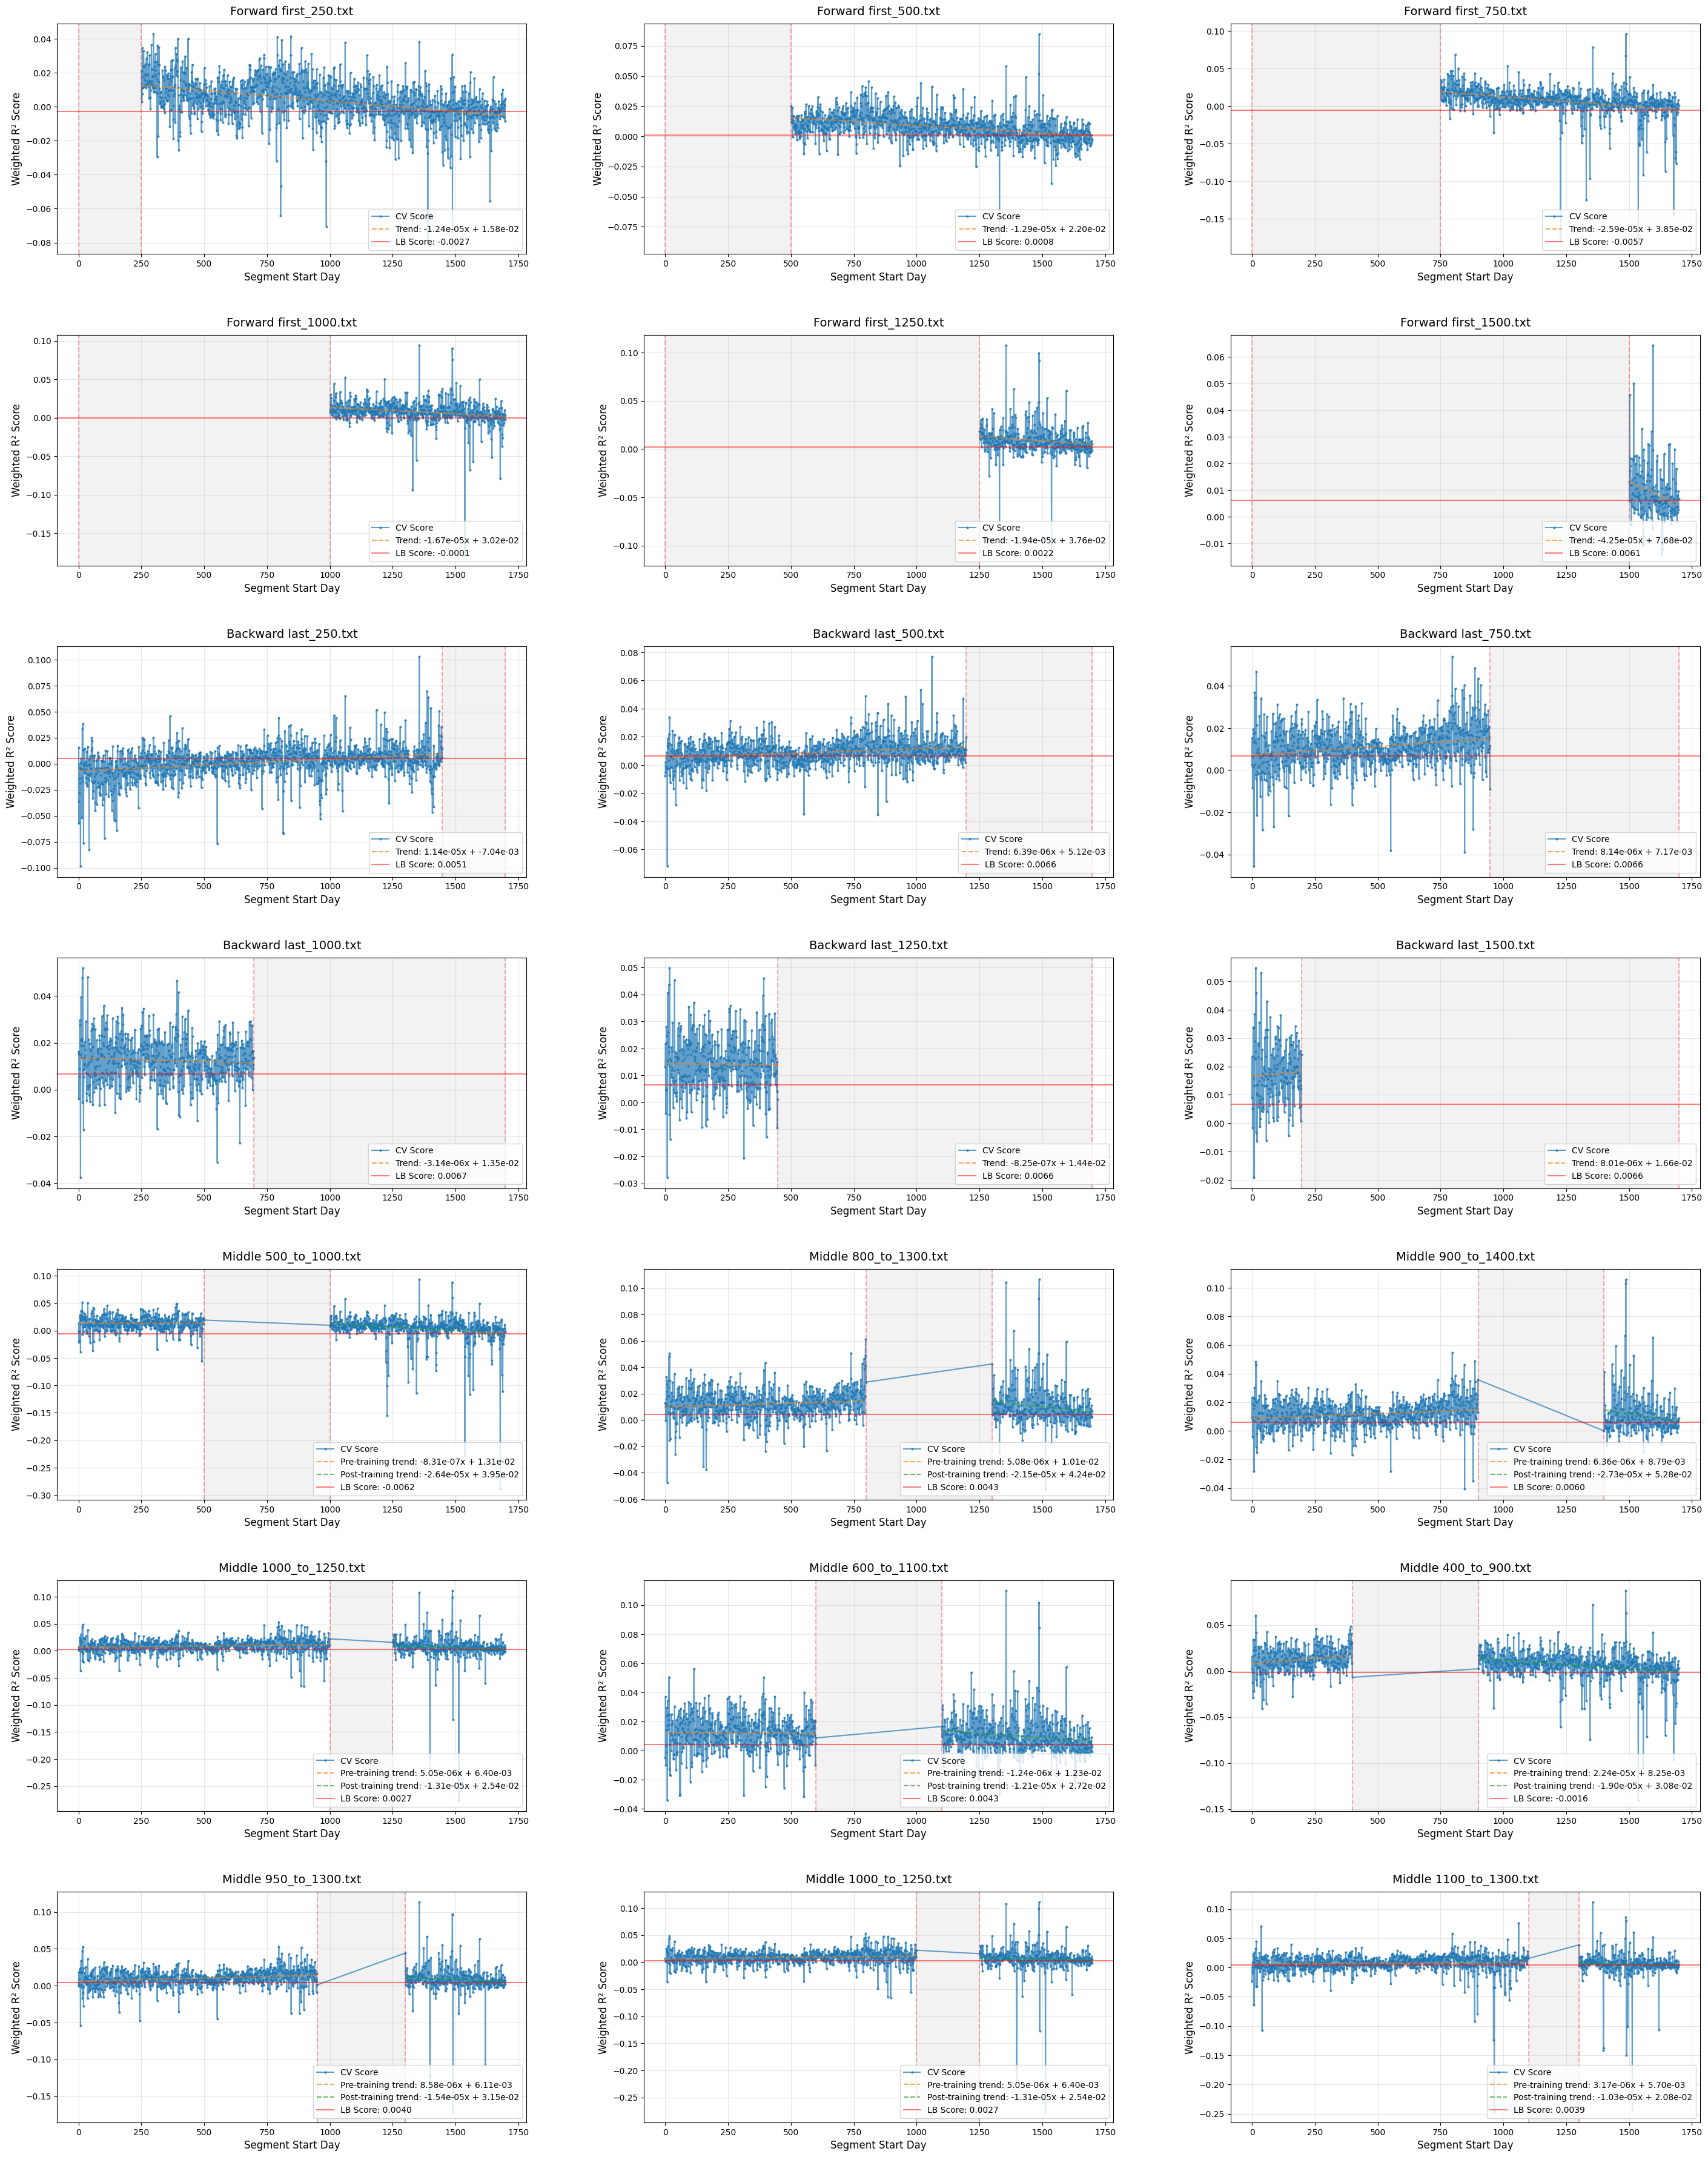

In [74]:
# Define LB scores
LB_SCORES = {
    'first_250.txt': -0.0027,
    'first_500.txt': 0.0008,
    'first_750.txt': -0.0057,
    'first_1000.txt': -0.0001,
    'first_1250.txt': 0.0022,
    'first_1500.txt': 0.0061,

    'last_250.txt': 0.0051,
    'last_500.txt': 0.0066,
    'last_750.txt': 0.0066,
    'last_1000.txt': 0.0067,
    'last_1250.txt': 0.0066,
    'last_1500.txt': 0.0066,

    '500_to_1000.txt': -0.0062,
    '800_to_1300.txt': 0.0043,
    '900_to_1400.txt': 0.0060,
    '400_to_900.txt': -0.0016,
    '600_to_1100.txt': 0.0043,
    '950_to_1300.txt': 0.0040,
    '1100_to_1300.txt': 0.0039,
    '1000_to_1250.txt': 0.0027
}

# Create subplot grid (6x3)
fig = plt.figure(figsize=(35, 45))  # Even bigger
gs = fig.add_gridspec(7, 3, hspace=0.35, wspace=0.25)  # Slightly more spacing
axes = gs.subplots(squeeze=True).flatten()

# For correlation analysis
cv_lb_comparison = {
    'model_name': [],
    'lb_score': [],
    'final_cv_score': []
}

# Plot each model in its own subplot
for idx, model_config in enumerate(MODELS):
    model_name = model_config['name']
    train_start = model_config['train_start']
    train_end = model_config['train_end']
    r2_col = f'r2_score_{model_name}'
    is_forward = model_name.startswith('first')
    is_backward = model_name.startswith('last')
    is_middle = not (is_forward or is_backward)
    lb_score = LB_SCORES[model_name]
    
    # Get valid results
    valid_results = results_df[
        (results_df['start_day'] < train_start) | (results_df['start_day'] > train_end)
    ][['start_day', r2_col]].dropna()
    
    if len(valid_results) > 0:
        cv_lb_comparison['model_name'].append(model_name)
        cv_lb_comparison['lb_score'].append(lb_score)
        cv_lb_comparison['final_cv_score'].append(valid_results[r2_col].iloc[-1])
    
    # Plot scores
    axes[idx].plot(valid_results['start_day'], valid_results[r2_col], 
                  marker='o', markersize=2,
                  label='CV Score', alpha=0.7)
    
    # Add trend line(s)
    if len(valid_results) > 0:
        if is_middle:
            # Split into before and after training period
            before_results = valid_results[valid_results['start_day'] < train_start]
            after_results = valid_results[valid_results['start_day'] > train_end]
            
            # Trend line for before period
            if len(before_results) > 0:
                z = np.polyfit(before_results['start_day'], before_results[r2_col], 1)
                p = np.poly1d(z)
                axes[idx].plot(before_results['start_day'], p(before_results['start_day']), 
                          "--", alpha=0.7,
                          label=f'Pre-training trend: {z[0]:.2e}x + {z[1]:.2e}')
            
            # Trend line for after period
            if len(after_results) > 0:
                z = np.polyfit(after_results['start_day'], after_results[r2_col], 1)
                p = np.poly1d(z)
                axes[idx].plot(after_results['start_day'], p(after_results['start_day']), 
                          "--", alpha=0.7,
                          label=f'Post-training trend: {z[0]:.2e}x + {z[1]:.2e}')
        else:
            z = np.polyfit(valid_results['start_day'], valid_results[r2_col], 1)
            p = np.poly1d(z)
            axes[idx].plot(valid_results['start_day'], p(valid_results['start_day']), 
                      "--", alpha=0.7,
                      label=f'Trend: {z[0]:.2e}x + {z[1]:.2e}')
    
    # Add LB score line
    axes[idx].axhline(y=lb_score, color='r', linestyle='-', 
                     label=f'LB Score: {lb_score:.4f}', alpha=0.5)
    
    # Add vertical lines showing training period
    axes[idx].axvline(x=train_start, color='r', linestyle='--', alpha=0.3)
    axes[idx].axvline(x=train_end, color='r', linestyle='--', alpha=0.3)
    axes[idx].axvspan(train_start, train_end, color='gray', alpha=0.1)
    
    # Customize subplot
    model_type = "Forward" if is_forward else ("Backward" if is_backward else "Middle")
    axes[idx].set_title(f'{model_type} {model_name}', fontsize=14, pad=10)
    axes[idx].set_xlabel('Segment Start Day', fontsize=12)
    axes[idx].set_ylabel('Weighted R² Score', fontsize=12)
    axes[idx].tick_params(axis='both', labelsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='lower right', fontsize=10)  # Fixed legend position

# Remove extra subplots
for idx in range(len(MODELS), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

## It looks like there is a consistent drop-off between ALL models for their post-training data points. We can use this to weight our validation and better estimate true LB scores!

In [75]:
# Store pre and post trend lines separately
pre_trends = {}
post_trends = {}

total_training_days = []

for model_config in MODELS:
    model_name = model_config['name']
    train_start = model_config['train_start']
    train_end = model_config['train_end']
    total_days = train_end - train_start
    total_training_days.append(total_days)

    r2_col = f'r2_score_{model_name}'
    is_forward = model_name.startswith('first')
    is_backward = model_name.startswith('last')
    is_middle = not (is_forward or is_backward)

    # Get valid results
    valid_results = results_df[
        (results_df['start_day'] < train_start) | (results_df['start_day'] > train_end)
    ][['start_day', r2_col]].dropna()

    if len(valid_results) > 0:
        if is_middle:
            # Split into before and after training period
            before_results = valid_results[valid_results['start_day'] < train_start]
            after_results = valid_results[valid_results['start_day'] > train_end]

            # Trend line for before period
            if len(before_results) > 0:
                z = np.polyfit(before_results['start_day'], before_results[r2_col], 1)
                pre_trends[f"{model_name}"] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': before_results['start_day'] - train_start
                }

            # Trend line for after period
            if len(after_results) > 0:
                z = np.polyfit(after_results['start_day'], after_results[r2_col], 1)
                post_trends[f"{model_name}"] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': after_results['start_day'] - train_end
                }
        else:
            z = np.polyfit(valid_results['start_day'], valid_results[r2_col], 1)
            if is_forward:
                post_trends[model_name] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': valid_results['start_day'] - train_end
                }
            else:  # backward
                pre_trends[model_name] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': valid_results['start_day'] - train_start
                }

# Print pre-training trend lines
print("\nPre-training trend lines (predictions before training period):")
print("-" * 80)
print(f"{'Model':<20} {'Slope':<15} {'Intercept':<15}       {'Total Days':<10}")
print("-" * 80)

sorted_pre = sorted(pre_trends.items(), key=lambda x: abs(x[1]['slope']), reverse=True)
for model_name, trend in sorted_pre:
    total_days = next(m['train_end'] - m['train_start'] for m in MODELS if m['name'] == model_name)
    print(f"{model_name:<20} {trend['slope']:.2e}        {trend['intercept']:.2e}       {total_days:<10}")

pre_slopes = [trend['slope'] for trend in pre_trends.values()]
print(f"\nPre-training average slope: {np.mean(pre_slopes):.2e}")
print(f"Pre-training slope std dev: {np.std(pre_slopes):.2e}")

# Print post-training trend lines
print("\nPost-training trend lines (predictions after training period):")
print("-" * 80)
print(f"{'Model':<20} {'Slope':<15} {'Intercept':<15}        {'Total Days':<10}")
print("-" * 80)

sorted_post = sorted(post_trends.items(), key=lambda x: abs(x[1]['slope']), reverse=True)
for model_name, trend in sorted_post:
    total_days = next(m['train_end'] - m['train_start'] for m in MODELS if m['name'] == model_name)
    print(f"{model_name:<20} {trend['slope']:.2e}        {trend['intercept']:.2e}        {total_days:<10}")

post_slopes = [trend['slope'] for trend in post_trends.values()]
print(f"\nPost-training average slope: {np.mean(post_slopes):.2e}")
print(f"Post-training slope std dev: {np.std(post_slopes):.2e}")



Pre-training trend lines (predictions before training period):
--------------------------------------------------------------------------------
Model                Slope           Intercept             Total Days
--------------------------------------------------------------------------------
400_to_900.txt       2.24e-05        8.25e-03       500       
last_250.txt         1.14e-05        -7.04e-03       250       
950_to_1300.txt      8.58e-06        6.11e-03       350       
last_750.txt         8.14e-06        7.17e-03       750       
last_1500.txt        8.01e-06        1.66e-02       1500      
last_500.txt         6.39e-06        5.12e-03       500       
900_to_1400.txt      6.36e-06        8.79e-03       500       
800_to_1300.txt      5.08e-06        1.01e-02       500       
1000_to_1250.txt     5.05e-06        6.40e-03       250       
1100_to_1300.txt     3.17e-06        5.70e-03       200       
last_1000.txt        -3.14e-06        1.35e-02       1000      
600_to_11

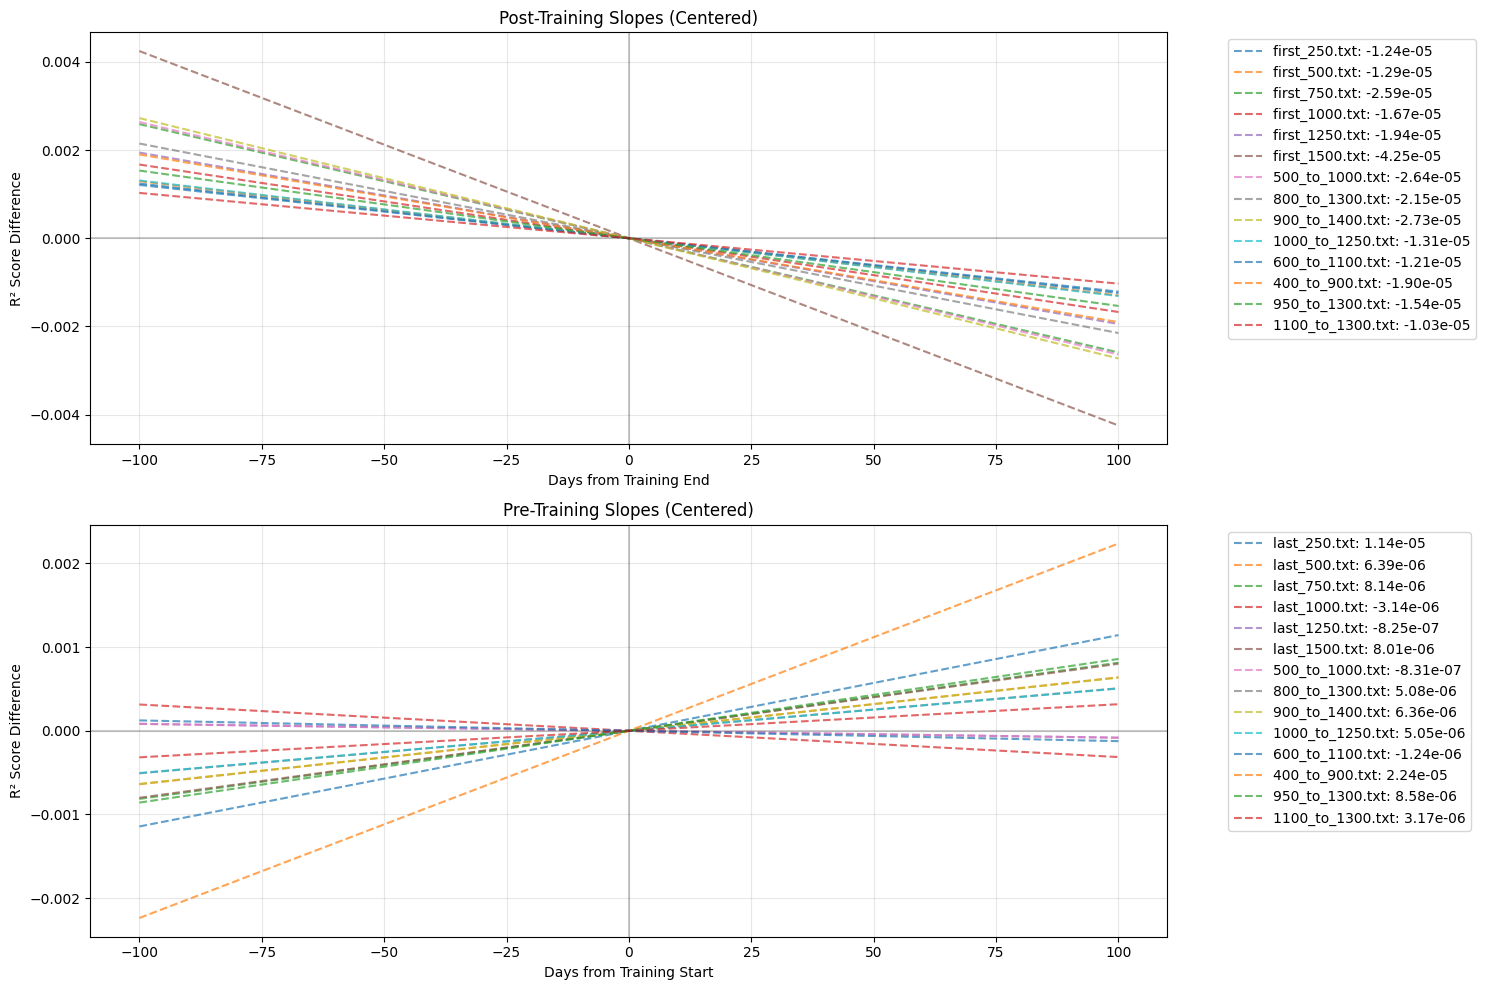


Detailed Statistical Analysis
--------------------------------------------------------------------------------
Pre-training slopes:
Mean: 5.61e-06
Median: 5.72e-06
Std Dev: 6.27e-06
Range: -3.14e-06 to 2.24e-05
Interquartile Range: 7.93e-06

Post-training slopes:
Mean: -1.96e-05
Median: -1.79e-05
Std Dev: 8.36e-06
Range: -4.25e-05 to -1.03e-05
Interquartile Range: 1.18e-05

Normality Tests (p-values):
Pre-training slopes: 0.0369
Post-training slopes: 0.0120

Levene's test for variance equality:
F-statistic: 0.8143
p-value: 0.3751

Correlation with training window size:
Pre-training: r=-0.2205 (p=0.4487)
Post-training: r=-0.6812 (p=0.0073)


/monfs01/projects/ys68/v_envs/simxrd_env/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot post-training slopes
for model_name, trend in post_trends.items():
    # Create x-axis centered at 0
    x = np.linspace(-100, 100, 200)  # arbitrary range to show slope
    y = trend['slope'] * x
    ax1.plot(x, y, '--', alpha=0.7, label=f"{model_name}: {trend['slope']:.2e}")

ax1.set_title('Post-Training Slopes (Centered)')
ax1.set_xlabel('Days from Training End')
ax1.set_ylabel('R² Score Difference')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.2)
ax1.axvline(x=0, color='k', linestyle='-', alpha=0.2)

# Plot pre-training slopes
for model_name, trend in pre_trends.items():
    x = np.linspace(-100, 100, 200)
    y = trend['slope'] * x
    ax2.plot(x, y, '--', alpha=0.7, label=f"{model_name}: {trend['slope']:.2e}")

ax2.set_title('Pre-Training Slopes (Centered)')
ax2.set_xlabel('Days from Training Start')
ax2.set_ylabel('R² Score Difference')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.2)
ax2.axvline(x=0, color='k', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.show()

# Statistical Analysis
print("\nDetailed Statistical Analysis")
print("-" * 80)

# Analyze slope distributions
pre_slopes = np.array([trend['slope'] for trend in pre_trends.values()])
post_slopes = np.array([trend['slope'] for trend in post_trends.values()])

print("Pre-training slopes:")
print(f"Mean: {np.mean(pre_slopes):.2e}")
print(f"Median: {np.median(pre_slopes):.2e}")
print(f"Std Dev: {np.std(pre_slopes):.2e}")
print(f"Range: {np.min(pre_slopes):.2e} to {np.max(pre_slopes):.2e}")
print(f"Interquartile Range: {np.percentile(pre_slopes, 75) - np.percentile(pre_slopes, 25):.2e}")

print("\nPost-training slopes:")
print(f"Mean: {np.mean(post_slopes):.2e}")
print(f"Median: {np.median(post_slopes):.2e}")
print(f"Std Dev: {np.std(post_slopes):.2e}")
print(f"Range: {np.min(post_slopes):.2e} to {np.max(post_slopes):.2e}")
print(f"Interquartile Range: {np.percentile(post_slopes, 75) - np.percentile(post_slopes, 25):.2e}")

# Test for normality
_, pre_norm_p = stats.normaltest(pre_slopes)
_, post_norm_p = stats.normaltest(post_slopes)

print("\nNormality Tests (p-values):")
print(f"Pre-training slopes: {pre_norm_p:.4f}")
print(f"Post-training slopes: {post_norm_p:.4f}")

# Test for slope consistency
f_stat, var_p = stats.levene(pre_slopes, post_slopes)

print("\nLevene's test for variance equality:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {var_p:.4f}")

# Correlation analysis
pre_training_days = [next(m['train_end'] - m['train_start'] for m in MODELS if m['name'] == model) 
                    for model in pre_trends.keys()]
post_training_days = [next(m['train_end'] - m['train_start'] for m in MODELS if m['name'] == model) 
                     for model in post_trends.keys()]

pre_corr, pre_p = stats.pearsonr(pre_training_days, pre_slopes)
post_corr, post_p = stats.pearsonr(post_training_days, post_slopes)

print("\nCorrelation with training window size:")
print(f"Pre-training: r={pre_corr:.4f} (p={pre_p:.4f})")
print(f"Post-training: r={post_corr:.4f} (p={post_p:.4f})")

### It would be cool if this pattern also went backwards (It would allow me to do more quirky CV stuff), it almost looked like it could have, but I would need more data to confirm. But also, if it is random, it means I can ignore it? Do more tests.

## Correlated scores val-LB (I don't think decay adjusted days help)

In [124]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Configuration
SIGNIFICANCE_LEVEL = 0.01  # p-value threshold
BIN_SIZES = range(2, 50)  # Bin sizes to test

# Store results for all bin sizes
all_bin_results = []

# Iterate over bin sizes
for bin_size in BIN_SIZES:
    bins = list(range(0, 1700, bin_size))

    for bin_start in bins:
        bin_end = bin_start + bin_size

        # For this bin, collect performances of all models that weren't training
        bin_performances = {
            'model': [],
            'r2_score': [],
            'lb_score': []
        }

        for model_config in MODELS:
            model_name = model_config['name']
            train_start = model_config['train_start']
            train_end = model_config['train_end']
            r2_col = f'r2_score_{model_name}'

            # Skip if model was training during this period
            if bin_start >= train_start and bin_start <= train_end:
                continue

            # Get average performance in bin
            valid_results = results_df[
                (results_df['start_day'] >= bin_start) & 
                (results_df['start_day'] < bin_end)
            ][['start_day', r2_col]].dropna()

            if len(valid_results) > 0:
                bin_score = valid_results[r2_col].mean()
                bin_performances['model'].append(model_name)
                bin_performances['r2_score'].append(bin_score)
                bin_performances['lb_score'].append(LB_SCORES[model_name])

        # Calculate correlations if we have enough models
        if len(bin_performances['model']) > 2:
            pearson_r, p_value = stats.pearsonr(
                bin_performances['r2_score'],
                bin_performances['lb_score']
            )
            spearman_r, spearman_p = stats.spearmanr(
                bin_performances['r2_score'],
                bin_performances['lb_score']
            )

            # Store significant segments
            if p_value < SIGNIFICANCE_LEVEL:
                all_bin_results.append({
                    'bin_size': bin_size,
                    'bin_start': bin_start,
                    'bin_end': bin_end,
                    'pearson_r': pearson_r,
                    'spearman_r': spearman_r,
                    'p_value': p_value,
                    'spearman_p': spearman_p,
                    'n_models': len(bin_performances['model'])
                })

# Convert to DataFrame
significant_results_df = pd.DataFrame(all_bin_results)

# Group overlapping segments together
def group_overlapping_segments(significant_results_df):
    # Sort by bin_start for logical grouping
    significant_results_df = significant_results_df.sort_values(['bin_start', 'bin_end'])

    grouped_segments = []
    current_group = []
    last_end = -1

    for _, row in significant_results_df.iterrows():
        if row['bin_start'] <= last_end:  # Overlap detected
            current_group.append(row)
        else:  # No overlap, start a new group
            if current_group:
                grouped_segments.append(current_group)
            current_group = [row]
        last_end = max(last_end, row['bin_end'])

    # Add the last group
    if current_group:
        grouped_segments.append(current_group)

    return grouped_segments

# Group overlapping segments
grouped_results = group_overlapping_segments(significant_results_df)

# Display grouped results
for i, group in enumerate(grouped_results):
    print(f"\nGroup {i + 1}:")
    print("-" * 80)
    group_df = pd.DataFrame(group)
    print(group_df.to_string(index=False))



Group 1:
--------------------------------------------------------------------------------
 bin_size  bin_start  bin_end  pearson_r  spearman_r  p_value  spearman_p  n_models
      2.0       46.0     48.0   0.666808    0.805821 0.006626    0.000287      15.0

Group 2:
--------------------------------------------------------------------------------
 bin_size  bin_start  bin_end  pearson_r  spearman_r  p_value  spearman_p  n_models
      2.0      388.0    390.0  -0.654755   -0.389941 0.008076    0.150764      15.0

Group 3:
--------------------------------------------------------------------------------
 bin_size  bin_start  bin_end  pearson_r  spearman_r  p_value  spearman_p  n_models
      7.0      399.0    406.0   0.661209    0.733161 0.007271    0.001871      15.0
      3.0      402.0    405.0   0.719627    0.788495 0.003712    0.000805      14.0
      2.0      404.0    406.0   0.708166    0.518280 0.004593    0.057613      14.0

Group 4:
---------------------------------------------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Define validation windows
VAL_WINDOWS = [
    {"start": 399, "end": 406},
    {"start": 624, "end": 632},
    {"start": 1216, "end": 1235},
    {"start": 1302, "end": 1316},
    {"start": 1422, "end": 1440},
    {"start": 1518, "end": 1564},
    {"start": 1638, "end": 1680}
]

def analyze_cv_structure(val_windows, total_days=1699):
    """Analyze the cross-validation structure and calculate statistics"""
    # Calculate basic statistics
    total_val_days = sum(w['end'] - w['start'] + 1 for w in val_windows)
    val_percentages = [(w['end'] - w['start'] + 1) / total_val_days * 100 for w in val_windows]
    
    # Calculate gaps between windows
    gaps = []
    for i in range(len(val_windows) - 1):
        gap = val_windows[i + 1]['start'] - val_windows[i]['end']
        gaps.append(gap)
    
    # Calculate correlations and p-values for each window
    window_stats = []
    for window in val_windows:
        # Filter results for this window
        window_results = results_df[
            (results_df['start_day'] >= window['start']) & 
            (results_df['start_day'] <= window['end'])
        ]
        
        # Get all models that weren't training during this period
        valid_models = []
        valid_lb_scores = []
        valid_val_scores = []
        
        for model_config in MODELS:
            model_name = model_config['name']
            train_start = model_config['train_start']
            train_end = model_config['train_end']
            r2_col = f'r2_score_{model_name}'
            
            # Skip if model was training during this period
            if window['start'] >= train_start and window['start'] <= train_end:
                continue
                
            if model_name in LB_SCORES:
                avg_val_score = window_results[r2_col].mean()
                valid_models.append(model_name)
                valid_lb_scores.append(LB_SCORES[model_name])
                valid_val_scores.append(avg_val_score)
        
        # Calculate correlation
        if len(valid_models) > 2:
            pearson_r, p_value = stats.pearsonr(valid_val_scores, valid_lb_scores)
        else:
            pearson_r, p_value = np.nan, np.nan
            
        window_stats.append({
            'start': window['start'],
            'end': window['end'],
            'length': window['end'] - window['start'] + 1,
            'n_models': len(valid_models),
            'correlation': pearson_r,
            'p_value': p_value
        })
    
    return pd.DataFrame(window_stats), total_val_days, gaps

def plot_cv_structure(val_windows, window_stats, total_days=1699, figsize=(20, 10)):
    """Create visualization of the cross-validation structure"""
    plt.figure(figsize=figsize)
    
    # Create main timeline
    plt.plot([0, total_days], [1, 1], 'k-', alpha=0.3)
    
    # Plot validation windows
    colors = plt.cm.viridis(np.linspace(0, 1, len(val_windows)))
    
    for i, (window, stats) in enumerate(zip(val_windows, window_stats.itertuples())):
        # Plot window
        plt.plot([window['start'], window['end']], [1, 1], 
                linewidth=10, solid_capstyle='butt',
                color=colors[i], alpha=0.7,
                label=f"Window {i+1}: {window['start']}-{window['end']}")
        
        # Add correlation text
        plt.text(window['start'], 1.1, 
                f"r={stats.correlation:.3f}\np={stats.p_value:.3e}\nn={stats.n_models}",
                rotation=45, ha='left', va='bottom')
    
    # Customize plot
    plt.ylim(0.5, 2)
    plt.xlim(-50, total_days + 50)
    plt.title("Cross-validation Structure", pad=20, fontsize=14)
    plt.xlabel("Day", fontsize=12)
    plt.yticks([])
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Calculate suggested weights
    weights = calculate_window_weights(window_stats)
    
    # Print statistics
    stats_text = f"""
    Total validation days: {sum(w['end'] - w['start'] + 1 for w in val_windows)}
    Percentage of total days: {sum(w['end'] - w['start'] + 1 for w in val_windows) / total_days * 100:.1f}%
    
    Suggested window weights (normalized):
    """
    
    for i, w in enumerate(weights):
        stats_text += f"Window {i+1}: {w:.3f}\n"
    
    plt.figtext(1.05, 0.5, stats_text, va='center')
    
    plt.tight_layout()
    plt.show()
    
    return weights

def calculate_window_weights(window_stats):
    """Calculate suggested weights for each validation window"""
    # Combine correlation strength, statistical significance, and window length
    raw_weights = []
    
    for stats in window_stats.itertuples():
        # Convert p-value to confidence factor (1 - p_value)
        confidence = 1 - stats.p_value
        
        # Combine factors:
        # - Absolute correlation (how well it predicts LB)
        # - Statistical confidence (1 - p-value)
        # - Window length (longer windows get more weight)
        # - Number of models (more models = more reliable correlation)
        weight = (abs(stats.correlation) * 
                 confidence * 
                 stats.length * 
                 np.log1p(stats.n_models))
        
        raw_weights.append(weight)
    
    # Normalize weights
    weights = np.array(raw_weights)
    weights = weights / weights.sum()
    
    return weights

# Run analysis
window_stats, total_val_days, gaps = analyze_cv_structure(VAL_WINDOWS)
weights = plot_cv_structure(VAL_WINDOWS, window_stats)